In [74]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout, Flatten, SpatialDropout1D
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix, getSpansByToxicWords
from keras import Sequential

In [75]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [76]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [77]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_train.csv")
train_df_preprocessed = train_data_semeval.preprocess()

In [79]:
extra_train = JigsawData(MAX_WORD_NUM)
extra_train.load_data("data/train.csv")
extra_df_preprocessed = extra_train.preprocess()

In [80]:
print(train_df_preprocessed)
print(train_data_semeval.get_classes_amount(train_df_preprocessed))
##add data 
additional_data = extra_train.get_missing_class_elements(extra_df_preprocessed, 100, 0.0)
print(additional_data)
frames = [train_df_preprocessed, additional_data]
train_df_preprocessed = pd.concat(frames)
# train_df_preprocessed
print(train_data_semeval.get_classes_amount(train_df_preprocessed))

                                                  spans  \
0     [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...   
1                          [33, 34, 35, 36, 37, 38, 39]   
2                                          [0, 1, 2, 3]   
3             [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]   
4                          [32, 33, 34, 35, 36, 37, 38]   
...                                                 ...   
7934                                     [8, 9, 10, 11]   
7935  [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5...   
7936  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
7937                            [5, 6, 7, 8, 9, 10, 11]   
7938  [106, 107, 108, 109, 110, 169, 170, 171, 172, ...   

                                                   text  toxicity  \
0     another violent and aggressive immigrant killi...         1   
1     i am 56 years old, i am not your fucking junio...         1   
2                     damn, a whole family. sad indeed.         1   
3     what a kn

In [81]:
train_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,toxicity_sentence
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...,1.0,[violent and aggressive immigrant],Another violent and aggressive immigrant killi...,[another violent and aggressive immigrant kill...,[1.0]
1,"[33, 34, 35, 36, 37, 38, 39]","i am 56 years old, i am not your fucking junio...",1.0,[fucking],"I am 56 years old, I am not your fucking junio...","[i am 56 years old, i am not your fucking juni...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,"[0, 1, 2, 3]","damn, a whole family. sad indeed.",1.0,[damn],"Damn, a whole family. Sad indeed.","[damn, a whole family., sad indeed.]","[1.0, 0.0]"
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead. how can anyone not know th...,1.0,[knucklehead],What a knucklehead. How can anyone not know th...,"[what a knucklehead., how can anyone not know ...","[1.0, 0.0, 0.0]"
4,"[32, 33, 34, 35, 36, 37, 38]",who do you think should do the killing? anyon...,1.0,[killing],"""who do you think should do the killing?""\n\nA...","[who do you think should do the killing?, anyo...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
36105,NaN,"dont try make an enemy of me, the discussion o...",0.0,NaN,NaN,"[dont try make an enemy of me, the discussion ...","[0.0, 0.0]"
153304,NaN,) can someone point me where to put a requist ...,0.0,NaN,NaN,[) can someone point me where to put a requist...,"[0.0, 0.0]"
156285,NaN,german or romanian? wouldnt it be more corre...,0.0,NaN,NaN,"[german or romanian?, wouldnt it be more corre...","[0.0, 0.0]"
71888,NaN,criticism section should be added is it not ...,0.0,NaN,NaN,[criticism section should be added is it not...,"[0.0, 0.0, 0.0]"


In [82]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###

In [83]:
train_df

,sentence,toxicity_sentence
0,another violent and aggressive immigrant killi...,1.0
1,"i am 56 years old, i am not your fucking junio...",1.0
2,what you are saying makes no sense.,0.0
3,i dont know what you are basing this on.,0.0
4,the cheap black market crap is still coming up...,0.0
...,...,...
23131,if not only the fact that the actual cost was ...,0.0
23132,"this not opinion, it is documented truth.",0.0
23133,hello and welcome to wikipedia.,0.0
23134,"just a note, if you wish to edit artocles as a...",0.0


In [84]:
train_df[train_df.toxicity_sentence == 0.0].shape

(14127, 2)

In [85]:
len(train_df)

23136

In [86]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [87]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [88]:
#filter stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
for i, w in enumerate(sentences):
    sentences[i] = [w for w in sentences[i] if not w in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
sentences = [x for x in sentences if x!=[]]

In [90]:
sentences 

[['another',
  'violent',
  'aggressive',
  'immigrant',
  'killing',
  'innocent',
  'intelligent',
  'us',
  'citizen',
  'sarcasm'],
 ['years', 'old', 'fucking', 'junior', 'pal'],
 ['saying', 'makes', 'sense'],
 ['dont', 'know', 'basing'],
 ['cheap',
  'black',
  'market',
  'crap',
  'still',
  'coming',
  'mexican',
  'nationals',
  'good',
  'stuff',
  'bc',
  'humbolt'],
 ['corridor', 'still', 'busy', 'still', 'making', 'ton', 'money'],
 ['nothing',
  'really',
  'changed',
  'except',
  'legal',
  'market',
  'made',
  'easy',
  'anyone',
  'legal',
  'age',
  'buy'],
 ['legal',
  'market',
  'controlled',
  'corporate',
  'growers',
  'million',
  'dollar',
  'facilities',
  'smaller',
  'growers'],
 ['federal',
  'government',
  'war',
  'drugs',
  'really',
  'impact',
  'legal',
  'market',
  'oregon'],
 ['dont', 'see', 'glutton', 'weed', 'whatever', 'means'],
 ['damn', 'whole', 'family'],
 ['sad', 'indeed'],
 ['knucklehead'],
 ['anyone', 'know', 'would', 'offensive'],
 ['t

In [91]:
len(sentences)

22660

In [92]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

In [93]:
word_index

{'stupid': 1,
 'trump': 2,
 'like': 3,
 'people': 4,
 'one': 5,
 'dont': 6,
 'get': 7,
 'would': 8,
 'idiot': 9,
 'think': 10,
 'know': 11,
 'us': 12,
 'right': 13,
 'idiots': 14,
 'time': 15,
 'go': 16,
 'even': 17,
 'see': 18,
 'ignorant': 19,
 'really': 20,
 'good': 21,
 'youre': 22,
 'make': 23,
 'cant': 24,
 'well': 25,
 'way': 26,
 'going': 27,
 'need': 28,
 'want': 29,
 'never': 30,
 'hes': 31,
 'white': 32,
 'president': 33,
 'stupidity': 34,
 'many': 35,
 'thats': 36,
 'much': 37,
 'another': 38,
 'country': 39,
 'man': 40,
 'left': 41,
 'say': 42,
 'nothing': 43,
 'world': 44,
 'take': 45,
 'dumb': 46,
 'every': 47,
 'years': 48,
 'back': 49,
 'thing': 50,
 'could': 51,
 'money': 52,
 'said': 53,
 'government': 54,
 'im': 55,
 'pathetic': 56,
 'fool': 57,
 'look': 58,
 'doesnt': 59,
 'still': 60,
 'state': 61,
 'racist': 62,
 'better': 63,
 'keep': 64,
 'moron': 65,
 'anyone': 66,
 'enough': 67,
 'anything': 68,
 'canada': 69,
 'real': 70,
 'crap': 71,
 'liberal': 72,
 'also'

In [94]:
import gensim

In [95]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [96]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [97]:
word_index.items()

dict_items([('stupid', 1), ('trump', 2), ('like', 3), ('people', 4), ('one', 5), ('dont', 6), ('get', 7), ('would', 8), ('idiot', 9), ('think', 10), ('know', 11), ('us', 12), ('right', 13), ('idiots', 14), ('time', 15), ('go', 16), ('even', 17), ('see', 18), ('ignorant', 19), ('really', 20), ('good', 21), ('youre', 22), ('make', 23), ('cant', 24), ('well', 25), ('way', 26), ('going', 27), ('need', 28), ('want', 29), ('never', 30), ('hes', 31), ('white', 32), ('president', 33), ('stupidity', 34), ('many', 35), ('thats', 36), ('much', 37), ('another', 38), ('country', 39), ('man', 40), ('left', 41), ('say', 42), ('nothing', 43), ('world', 44), ('take', 45), ('dumb', 46), ('every', 47), ('years', 48), ('back', 49), ('thing', 50), ('could', 51), ('money', 52), ('said', 53), ('government', 54), ('im', 55), ('pathetic', 56), ('fool', 57), ('look', 58), ('doesnt', 59), ('still', 60), ('state', 61), ('racist', 62), ('better', 63), ('keep', 64), ('moron', 65), ('anyone', 66), ('enough', 67), ('

In [98]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=0
        absent_words+=1

In [99]:
len(word_index)

18686

In [100]:
### save toknizer to file so that it could be used again
import pickle

# saving

with open('tokenizer_nn.pickle', 'wb') as handle:

    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
absent_words

2928

In [102]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [103]:
data_index.shape

(22660, 40)

In [104]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  38 1154 3088 1950  291  670  898   12  958 3441    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  48  152  671 2592 1322    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 166  125  371    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   6   11 9821    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1265  131  619   71   60  308 2820 9822   21  402  757 9823    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [105]:
y_train.shape

(18128, 1)

In [106]:
y_val.shape

(4532, 1)

In [107]:
y_softmax_train = np.zeros((y_train.shape[0], 2))
y_softmax_val = np.zeros((y_val.shape[0], 2))

In [108]:
for i in range(0, y_softmax_train.shape[0]):
    if y_train[i] == 0:
        y_softmax_train[i][0] = 1
    else :
        y_softmax_train[i][1] = 1

In [109]:
for i in range(0, y_softmax_val.shape[0]):
    if y_val[i] == 0:
        y_softmax_val[i][0] = 1
    else :
        y_softmax_val[i][1] = 1

## Build model

In [110]:
model = Sequential()
model.add(Embedding(len(word_index)+1 ,EMBEDDING_DIM,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(EMBEDDING_DIM,dropout=0.3, recurrent_dropout=0.3), name='bidirectional'))
model.add(Dense(EMBEDDING_DIM, activation='relu', name='dense'))
model.add(Dropout(0.8))
model.add(Dense(EMBEDDING_DIM, activation='relu', name='dense2'))
model.add(Dropout(0.8))
model.add(Dense(2, activation='softmax', name='dense_final'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           5606100   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense2 (Dense)               (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)              

In [111]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           5606100   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense2 (Dense)               (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)              

Epoch 1/25
18/18 [==============================] - 82s 5s/step - loss: 0.6804 - acc: 0.5890 - val_loss: 0.6771 - val_acc: 0.5975
Epoch 2/25
18/18 [==============================] - 84s 5s/step - loss: 0.6760 - acc: 0.6033 - val_loss: 0.6766 - val_acc: 0.5975
Epoch 3/25
18/18 [==============================] - 84s 5s/step - loss: 0.6740 - acc: 0.6054 - val_loss: 0.6772 - val_acc: 0.5975
Epoch 4/25
18/18 [==============================] - 83s 5s/step - loss: 0.6731 - acc: 0.6046 - val_loss: 0.6757 - val_acc: 0.5975
Epoch 5/25
18/18 [==============================] - 80s 4s/step - loss: 0.6722 - acc: 0.6053 - val_loss: 0.6748 - val_acc: 0.5975
Epoch 6/25
18/18 [==============================] - 82s 5s/step - loss: 0.6718 - acc: 0.6057 - val_loss: 0.6768 - val_acc: 0.5975
Epoch 7/25
18/18 [==============================] - 84s 5s/step - loss: 0.6690 - acc: 0.6057 - val_loss: 0.6758 - val_acc: 0.5975
Epoch 8/25
18/18 [==============================] - 80s 4s/step - loss: 0.6668 - acc: 0.60

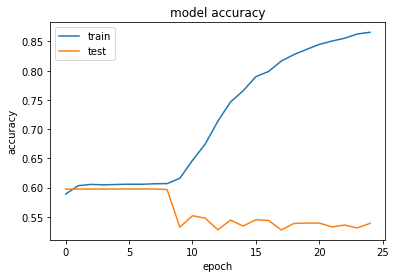

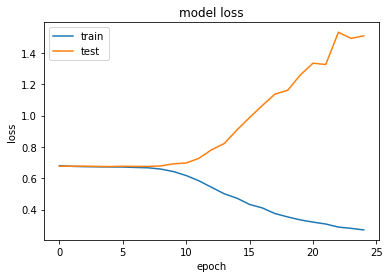

In [112]:
history = model.fit(x_train, y_softmax_train, validation_data=(x_val, y_softmax_val), epochs=25, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('lstm_w2v.h5')

### Explanation using LIME

For one example

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

In [40]:
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = y_val
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.77      0.72       303
         1.0       0.39      0.28      0.33       159

    accuracy                           0.60       462
   macro avg       0.53      0.53      0.52       462
weighted avg       0.58      0.60      0.58       462



In [41]:
from lime.lime_text import LimeTextExplainer

In [42]:
explainer = LimeTextExplainer(class_names=["NoToxic","Toxic"])

In [43]:
def new_predict_working(x):
    if not isinstance(x, list): 
        x = [x]
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return model.predict(data_temp)

In [44]:
def vectorize(x):
    if not isinstance(x, list): 
        x = [x]
    data_temp = np.zeros((len(x), MAX_WORD_NUM), dtype='int32')
    for i, sentence in enumerate(x):
        words = sentence.split(" ")
        for k, word in enumerate(words):
            try:
                if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                    data_temp[i,k] = tokenizer.word_index[word]
            except:
                pass
    return data_temp

In [45]:
string = ' '.join([str(elem) for elem in sentences[2]]) 

For all samples

In [46]:
class Transform():
    def __init__(self):
        print("")
    
    def fit(self, X, y = None):
        print("")
        return self
    
    def transform(self, X, y =None):
        X_ = vectorize(X)
        return X_
    

In [219]:
t = Transform()

In [220]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(Transform(),model)

In [221]:
exp = explainer.explain_instance(string,c.predict_proba, num_features=6, top_labels = 2)

In [282]:
def getPredictedWordsFromSentence(sentence, threshold):
    print(sentence)
    y_pred = new_predict_working([sentence])
    if np.argmax(y_pred) == 1 :
        predicted_words = []
        exp = explainer.explain_instance(sentence,c.predict_proba, num_features=6, top_labels = 2)
        expWords = exp.as_list()
        maxScore = max(expWords, key = lambda i : i[1])[0]
        expWords = filter(lambda t: t[1] > threshold, expWords )
        wordsList = [i[0] for i in expWords]
        wordsList.append(maxScore) if maxScore not in wordsList else wordsList
        return wordsList
    else : return []

In [1]:
pred = getPredictedWordsFromSentence(string, 0.25)

NameError: name 'getPredictedWordsFromSentence' is not defined

In [47]:
getSpansByToxicWords[pred, string]